<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/MCA_SDU_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos y Ubicuos II 

## MCA Tercer cuatrimestre

### Horacio Tapia-McClung



## Resumen Semana 1

* Como "guarda" informacion la computadora

In [0]:
import numpy as np
import pandas as pd
import psutil, os

def huella_memoria():
  '''Regresa la huella de memoria en MB usada por un proceso de Python'''
  mem = psutil.Process(os.getpid()).memory_info().rss
  return (mem / 1024**2)


antes = huella_memoria()
N = (1024**2)//8
x = np.random.rand(50*N)
despues = huella_memoria()
print('Memoria asignada a un arreglo: {} MB'.format(despues-antes))
print('Memoria utilizada por el arreglo: {} MB'.format(x.nbytes / (1024**2)))

antes = huella_memoria()
x**2
despues = huella_memoria()
print('Memoria asignada a una operacion: {} MB'.format(despues-antes))

df = pd.DataFrame(x)
print('Memoria utilizada por el DataFrame: {} MB'.format(df.memory_usage(index=False)/(1024**2)))



Memoria asignada a un arreglo: 0.0 MB
Memoria utilizada por el arreglo: 50.0 MB
Memoria asignada a una operacion: 49.96484375 MB
Memoria utilizada por el DataFrame: 0    50.0
dtype: float64 MB


# Semana 2

Ahora veremos como acceder a un conjunto de datos separandolo en partes y como podemos conocer las propiedades del conjunto compleo conociendo las propiedades de cada parte y agregando al final.
Esto es util y practico cuando tenemos un conjunto de datos grande como el siguiente:

In [0]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv

--2019-05-13 17:24:22--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.178.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.178.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772098307 (736M) [text/csv]
Saving to: ‘yellow_tripdata_2018-01.csv’

yellow_tripdata_201 100%[===================>] 736.33M  43.7MB/s    in 17s     

2019-05-13 17:24:39 (42.7 MB/s) - ‘yellow_tripdata_2018-01.csv’ saved [772098307/772098307]



In [0]:
archivo = 'yellow_tripdata_2018-01.csv'

In [0]:
for trozo in pd.read_csv(archivo, chunksize=500000):
  print('type: %s shape %s' % (type(trozo), trozo.shape))

type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (500000, 17)
type: <class 'pandas.core.frame.DataFrame'> forma (5000

In [0]:
trozo.shape

(259874, 17)

Cada trozo tiene los atributos estandares de un `DataFrame`

In [0]:
trozo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259874 entries, 8500000 to 8759873
Data columns (total 17 columns):
VendorID                 259874 non-null int64
tpep_pickup_datetime     259874 non-null object
tpep_dropoff_datetime    259874 non-null object
passenger_count          259874 non-null int64
trip_distance            259874 non-null float64
RatecodeID               259874 non-null int64
store_and_fwd_flag       259874 non-null object
PULocationID             259874 non-null int64
DOLocationID             259874 non-null int64
payment_type             259874 non-null int64
fare_amount              259874 non-null float64
extra                    259874 non-null float64
mta_tax                  259874 non-null float64
tip_amount               259874 non-null float64
tolls_amount             259874 non-null float64
improvement_surcharge    259874 non-null float64
total_amount             259874 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 33.7+ MB


Veamos como filtrar un trozo usando una condicion, en este caso decidiremos que un viaje es largo si distancia del viaje es mayor a 10 millas ( [ver aqui](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [0]:
es_un_viaje_largo = (trozo.trip_distance > 10)

In [0]:
trozo.loc[es_un_viaje_largo].shape

(11817, 17)

Ahora vamos a encapsular este filtrado en una funcion que acepta una estructura y regresa la estructura filtrada y luego vamos a iterar sobre los trozos

In [0]:
def filtra_es_viaje_largo(data):
  '''Returns DataFrame filtering trips with distance over 10 miles'''
  es_un_viaje_largo = (data.trip_distance > 10)
  return data.loc[es_un_viaje_largo]

In [0]:
trozos = []
for trozo in pd.read_csv(archivo, chunksize=500000):
  trozos.append(filtra_es_viaje_largo(trozo))

En lugar de inicializar una lista vacia `trozos=[]` tambien podemos usar una comprension de lista (list comprehension) equivalente al bucle anterior

In [0]:
trozos = [ filtra_es_viaje_largo(trozo) for trozo in pd.read_csv(archivo, chunksize=500000) ]

In [0]:
len(trozos)

18

Cada trozo filtrado tiene un tamaño menor a los 500000 originales

In [0]:
lengths = [len(trozo) for trozo in trozos]
lengths[-5:]

[24950, 22277, 27423, 23822, 11817]

In [0]:
np.mean(lengths)

25934.11111111111

Vamos a acomodar cada trozo en un `DataFrame` usando la funcion `concat` del `pandas` resultando en una estructura con casi 470m registros:

In [0]:
viajes_largos_df = pd.concat(trozos)
viajes_largos_df.shape

(466814, 17)

Ahora vamos a graficar  las distancias de los viajes filtrados contra el numero de pasajeros

In [0]:
import matplotlib.pyplot as plt

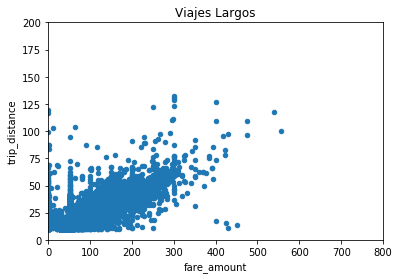

In [0]:
viajes_largos_df.plot.scatter(x='fare_amount', y='trip_distance',title='Viajes Largos',ylim=(0,200),xlim=(0,800))

## Generadores

Si reemplazamos los corchetes por parentesis en la expresion 
> `trozos = [ filtra_es_viaje_largo(trozo) for trozo in pd.read_csv(archivo, chunksize=500000) ]`
tendremos un generador. La diferencia es que los elementos se generan uno a uno asi que nunca usan memoria de manera simultanea (lazy evaluation).

In [0]:
trozos = (filtra_es_viaje_largo(trozo) for trozo in pd.read_csv(archivo, chunksize=500000)) 

In [0]:
distancias = (trozo['trip_distance'].sum() for trozo in trozos)

El codigo anterior NO hace ningun calculo hasta que se hace la operacion, esto se llama _consumir el generador_

In [0]:
sum(distancias)

7339629.629999999

In [0]:
distancias

<generator object <genexpr> at 0x7fbc2c5b9e08>

El generador ya esta consumido, no podemos accederlo mas

In [0]:
next(distancias)

StopIteration: ignored

## Leyendo varios archivos

In [0]:
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla

urls = (plantillaURL.format(k) for k in range(1,7)) # generator
for urls in urls:
  print(url)

wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-02.csv
wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv
wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv
wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv
wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-06.csv


Ahora vamos a descargar todos los archivos...necesitamos crear el generador de nuevo porque ya se consumio!

In [0]:
urls = (plantillaURL.format(k) for k in range(1,7)) # generator
for url in urls:
  os.system(url)

In [0]:
ls

sample_data/                   yellow_tripdata_2018-04.csv
yellow_tripdata_2018-01.csv    yellow_tripdata_2018-05.csv
yellow_tripdata_2018-01.csv.1  yellow_tripdata_2018-06.csv
yellow_tripdata_2018-02.csv    yellow_tripdata_2018-06.csv.1
yellow_tripdata_2018-03.csv


Examinemos uno de los archivos de ejemplo. ... . . .

In [0]:
df = pd.read_csv('yellow_tripdata_2018-01.csv', parse_dates=[1,2])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 17 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(8), int64(6), object(1)
memory usage: 1.1+ GB


Vamos a usar la siguiente funcion para determinar el tiempo de recorridos en cada viaje

In [0]:
def cuenta_viajes_largos(df):
  df['duracion'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
  es_viaje_largo = df.duracion > 1200 # viajes que duran mas de 20 minutos
  result_dict = {'n_long':[sum(es_viaje_largo)],
                'n_total':[len(df)]}
  return pd.DataFrame(result_dict)

In [0]:
archivos = [plantilla.format(k) for k in range(1,4)] # comprension de lista
archivos

['yellow_tripdata_2018-01.csv',
 'yellow_tripdata_2018-02.csv',
 'yellow_tripdata_2018-03.csv']

In [0]:
dataframes = (pd.read_csv(archivo, parse_dates=[1,2]) for archivo in archivos) # generador

In [0]:
totales = (cuenta_viajes_largos(df) for df in dataframes) #generador

In [0]:
totales_semianuales = sum(totales) # consume generadores

El dataframe que resulta contiene dos columnas, la razon entre ellas es la fraccion de viajes con una duracion mayor a 20 minutos de los viajes totales en la primera mitad del 2018

In [0]:
print(totales_semianuales)

     n_long   n_total
0  10954358  53925735


In [0]:
fraccion = totales_semianuales['n_long'] / totales_semianuales['n_total']
print(fraccion)

0    0.203138
dtype: float64


La introduccion de generadores permite aplazar calculos hasta que se consuman los generadores haciendo alguna operacion y control el uso de memora.
La libreria `dask` puede ayudar a automatiza esto...

In [0]:
from math import sqrt

In [0]:
def f(z):
  return sqrt(z + 4)

def g(y):
  return y - 3

def h(x):
  return x ** 2

In [0]:
x = 4


In [0]:
y = h(x)

In [0]:
z = g(y)

In [0]:
w = f(z)

In [0]:
print(w)

4.123105625617661


Esto no es mas que la composicion de funciones:

In [0]:
print(f(g(h(x))))

4.123105625617661


Repetiremos este calculo usando `delayed` de la libreria `dask` que es una funcion de orden alto o decorador, que mapea una funcion de entrada a otra funcion de salida modificada

In [0]:
from dask import delayed

In [0]:
y = delayed(h)(x)

In [0]:
z = delayed(g)(y)

In [0]:
w = delayed(f)(z)

In [0]:
print(w)

Delayed('f-df744d29-66be-4252-aa94-778d9ab6fa31')


In [0]:
type(w)

dask.delayed.Delayed

el decorador guarda el calculo hasta que se evalua 

In [0]:
w.compute()

4.123105625617661

In [0]:
w.visualize()

Podemos renombrar con decoradores

In [0]:
f = delayed(f)
g = delayed(g)
h = delayed(h)
w = f(g(h(4)))

In [0]:
type(w)

dask.delayed.Delayed

In [0]:
w.compute()

4.123105625617661

La decoracion anterior puede "simplificarse" de la siguiente forma.

In [0]:
def f(x):
  return sqrt(x + 4)

f = delayed(f)

In [0]:
type(f)

dask.delayed.DelayedLeaf

In [0]:
@delayed
def f(x):
  return sqrt(x + 4)

In [0]:
type(f)

dask.delayed.DelayedLeaf

Ejemplos

In [0]:
@delayed
def incrementa(x):
  return x + 1

In [0]:
@delayed
def dobla(x):
  return 2 * x

In [0]:
@delayed
def suma(x,y):
  return x + y

In [0]:
data = [1,2,3,4,5]

In [0]:
output = []

In [0]:
for x in data:
  a = incrementa(x)
  b = dobla(x)
  c = suma(a, b)
  output.append(c)

In [0]:
type(output)

list

In [0]:
output

[Delayed('suma-aa6816fa-8dec-4e63-8375-e837136e79e8'),
 Delayed('suma-5539dfee-a420-4b3a-9e28-a89adff883ba'),
 Delayed('suma-84ead70e-4e04-40a7-8129-a657419a3064'),
 Delayed('suma-71fecf5e-f4a9-42be-a528-0be2e32378a8'),
 Delayed('suma-ea480a69-0002-4420-9f31-45edf0f93f9d')]

In [0]:
total = sum(output)

In [0]:
type(total)

dask.delayed.Delayed

In [0]:
total

Delayed('add-1ee9a9519d642e1d5236fd6aeffe532f')

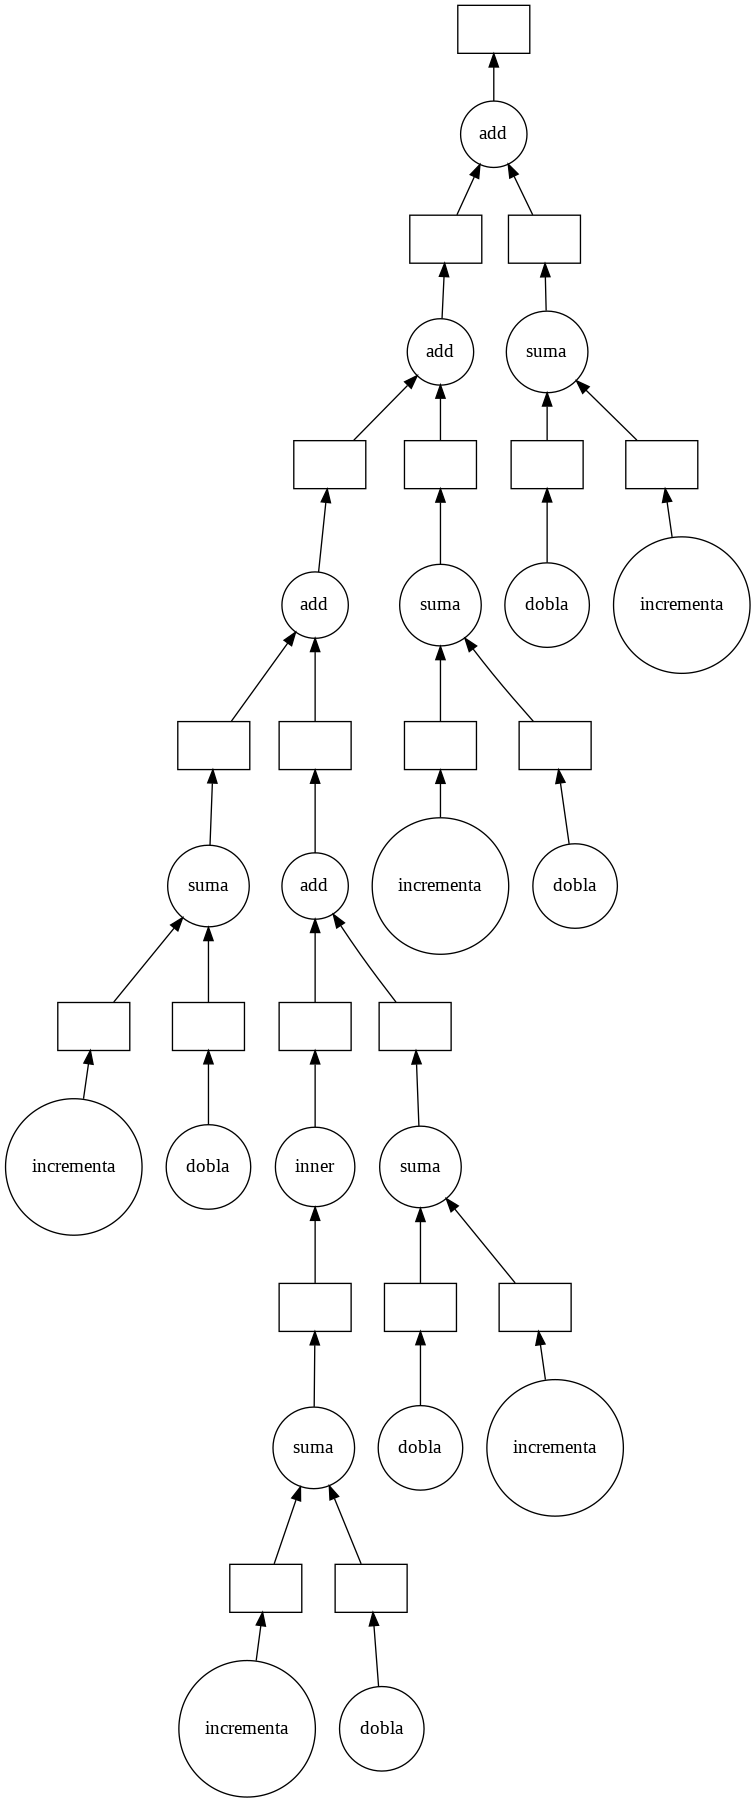

In [0]:
total.visualize()